In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [4]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1 # Greyscale images
num_classes = 10
batch_size = 128

In [5]:
# Conv Net Architecture
filter_size_l1 = 5
num_filters_l1 = 16

filter_size_l2 = 5
num_filters_l2 = 32

fc_size = 128

In [6]:
def plot_images(images, cls_true, cls_pred = None):
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

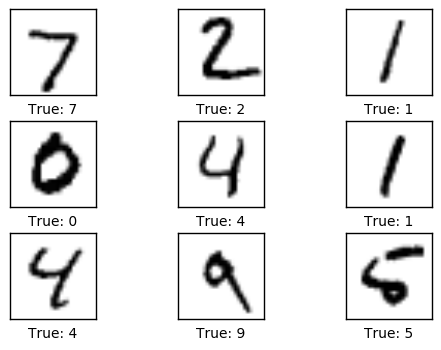

In [7]:
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

In [8]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [9]:
def new_bias(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [10]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling = True):
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    bias = new_bias(length=num_filters)
    layer = tf.nn.conv2d(input = input, filter=weights, strides=[1,1,1,1], padding='SAME')
    layer += bias
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

In [11]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [12]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu = True):
    weights = new_weights([num_inputs, num_outputs])
    biases = new_bias(num_outputs)
    layer = tf.add(tf.matmul(input, weights), biases)
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [13]:
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name='x')
x_image = tf.reshape(x, shape = [-1, img_size, img_size ,num_channels])
y_true = tf.placeholder(tf.float32, shape = [None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [14]:
layer_conv1, weight_conv1 = new_conv_layer(x_image, num_channels, filter_size_l1, num_filters_l1, True)
layer_conv2, weight_conv2 = new_conv_layer(layer_conv1, num_filters_l1, filter_size_l2, num_filters_l2, True)

In [15]:
layer_flat, num_features = flatten_layer(layer_conv2)
layer_fc1 = new_fc_layer(layer_flat, num_features, fc_size, True)
layer_fc2 = new_fc_layer(layer_fc1, fc_size, num_classes, False)

In [16]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [17]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(layer_fc2, y_true))
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [18]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [20]:
def optimize(num_iterations):
    for i in range(num_iterations):
        num_epochs = int(data.train.num_examples/batch_size)
        total_cost = 0
        for j in range(num_epochs):
            batch_x, batch_y = data.train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={x:batch_x, y_true:batch_y})
            total_cost += c
        print( 'Epoch - ', i, '; Cost - ', total_cost)

In [21]:
optimize(10)
acc = sess.run(accuracy, feed_dict={x: data.test.images, y_true: data.test.labels})
print('Accuracy achieved - ', acc)

Epoch -  0 ; Cost -  128.543948247
Epoch -  1 ; Cost -  30.3661027048
Epoch -  2 ; Cost -  19.8379011704
Epoch -  3 ; Cost -  14.7432381045
Epoch -  4 ; Cost -  11.8050319762
Epoch -  5 ; Cost -  9.56201476575
Epoch -  6 ; Cost -  7.63032543351
Epoch -  7 ; Cost -  6.36577909962
Epoch -  8 ; Cost -  5.51810411472
Epoch -  9 ; Cost -  4.51278348138
Accuracy achieved -  0.993


Incorrectly classified images


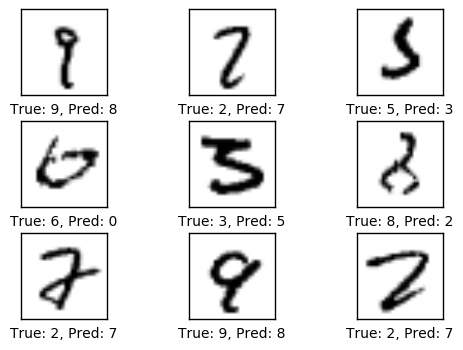

In [22]:
print('Incorrectly classified images')
correct, classification = sess.run([correct_prediction, y_pred_cls], feed_dict={x: data.test.images, y_true: data.test.labels})
incorrect = (correct == False)
i_images = data.test.images[incorrect]
i_pred = classification[incorrect]
i_labels = data.test.cls[incorrect]
plot_images(i_images[0:9], i_labels[0:9], i_pred[0:9])